In [26]:
#load "Aardvark.fsx"

In [27]:
open System
open Aardvark.Base
open Aardvark.Base.Rendering
open Aardvark.Base.Incremental
open Aardvark.SceneGraph
open Aardvark.Application
open Aardvark.Application.Slim


Aardvark.Notebooks.Setup.init()

let app = new OpenGlApplication()
let runtime = app.Runtime

temp for native dependencies: C:\Users\hs\AppData\Local\Temp\058bfc4d-7110-4880-89c4-c78db014fad5
 0: initializing mod system .......................................... 0.000 s
 0: initializing aardvark ....................................................
 0:   System Information:
 0:     OSVersion: Microsoft Windows NT 6.2.9200.0
 0:     SystemArchitecture: 64-bit
 0:     Environment.Version: 4.0.30319.42000
 0:   Loading plugins ................................................ 0.010 s
 0:   initializing SceneGraphCompletenessCheck ....................... 0.020 s
 0: initializing aardvark ............................................ 0.371 s
 0: initializing OpenGL runtime ..............................................
 0:   vendor:   "NVIDIA Corporation"
 0:   renderer: "GeForce GTX 1060 3GB/PCIe/SSE2"
 0:   version:  OpenGL 4.3.0 / GLSL 4.3
 0: initializing OpenGL runtime ...................................... 0.001 s


In [28]:
#load @"app/Model.fs"
#load @"app/Model.g.fs"


In [29]:
  
open Aardvark.Base
open Aardvark.Base.Rendering
open Aardvark.Base.Incremental
open Aardvark.SceneGraph
open Aardvark.Application

module Shader =
    open FShade 

    type Vertex =
        {
            [<Position>] pos    : V4d
            [<TexCoord;>] tc     : V2d
            [<SamplePosition>] s     : V2d
        }

    type UniformScope with
        member x.Iterations : int = x?Mandelbrot?Iterations
        member x.Scale : float = x?Mandelbrot?Scale
        member x.Center : V2d = x?Mandelbrot?Center

    let transfer =
        sampler2d {
            texture uniform?TransferFunction
            filter Filter.MinMagLinear
            addressU WrapMode.Wrap
            addressV WrapMode.Wrap
        }


    let mandelbrot (v : Vertex) =
        fragment {
            let scale = uniform.Scale
            let center = uniform.Center
            let size = uniform.ViewportSize
            let aspect = float size.X / float size.Y
            let iter = uniform.Iterations

            let c = V2d(aspect * (2.0 * v.tc.X - 1.0), (2.0 * v.tc.Y - 1.0)) * scale - center

            let mutable cont = true
            let mutable z = c
            let mutable i = 0
            while i < iter && cont do
                let x = (z.X * z.X - z.Y * z.Y) + c.X
                let y = (z.Y * z.X + z.X * z.Y) + c.Y
                
                if (x * x + y * y) > 4.0 then
                    cont <- false
                else
                    z <- V2d(x,y)
                    i <- i + 1

            let coord = if i = iter then 0.0 else float i / 100.0
            let color = transfer.SampleLevel(V2d(coord, 0.0), 0.0)

            return color


        }

{Html =
  "<img width='900' height='200' alt='tick' src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA4QAAAH0CAYAAABl8+PTAAAAP3RFWHRHZW5lcmF0ZWQgYnkAR2VuZXJhdGVkIGJ5IHRoZSBEZXZlbG9wZXIncyBJbWFnZSBMaWJyYXJ5IChEZXZJTCk++VvxAAAAB3RFWHRBdXRob3IAqa7MSAAAAAx0RVh0RGVzY3JpcHRpb24AEwkhIwAAIABJREFUeJzsnX18VOWZ978m54EJjmGSDDEq4AzBhhRNiEtang2GiixqVhTBVlGBbolaq6687dOCikUt1OcRwdqWVUNXUQTbiljdaC3SBUnXNtSQKIXUwERAjGECEUczsAd8/rjnZCaTmclMMq/J9f185jNv59znPi9zz/U713Vf11kafIXQL8hKdAeSHEuiOyAIKYyML+ETrbEmHse8L32NpH89bSdYW5YwlslMV8+aRT1MdsibC+ZZO+HDFXDRx8Bf4Mjj8MU7ALQVVpNzcCWcdkK6FbJmQIYV+DMVWgVZwEvh7pwgCEKKk5boDgjRQYy14FgQMSgIfUHGl/iT7Mc8mmIwXI5HsKz5S6B5Iq5d1cDfgZk8NnIJYwurcTdVM/h5cNcvgRM7MI9cAukF8FIO8BnV+ig2POZt66dR6r8gCEKyIoIwxcki+Q2HRCFCUBD6jowvkRGNMSdex7w3fU3G/5wTp9Wz3q4eAM5PoWUttO8A54oOVmqvs1jfyALA3Qxuh2fZzHJcFmDQKLhxFPA2rDkAj6h2TMDiJk/7enE8d0sQBCFunCUho6lJsv0hJxMiAgWh78gYEzn9PVS0N/0KdzvhhIyGWtY/bFTL8r432WH42pOgf0H7M9m4mz3fDQXr0lGg78JuyuYFoEzPoE3rIKd1C2QvBCZ7trCBw3d2YHsG9PpS9s2r5eJdYe5cAHbng2Uy2J7pfRuCIAjRQjyEKYgYat2xIB5BQYgWMsYkjv4kBhOB4SXUj3se7cob6FwxmJb7snE1gH5CPdyHwLniAFyfzT8CVgCu4wKjMedSIJP7tSo41cGVz8B6gA9qGVMEus+BrA2nb3olehmsAv5lv4hBQRCSBxGEKUQyhuokGhGBghBdZIzpHakSKhppP/vyv9PXY9KX9Y3QUf24RxD+Dlz1nlDRNvUA0D8D9w9gw1NQUAas24S7vQYOL4COvcAuHtHb4G6YAfwD0HYLtGTBtnbQW6rQL4HT6aDrJxkGVKIEov6lEo2780HfANxexYs1sAio68O+CYIgRBsJGU0BxEDrjohAQYg+Mtb0jv4sBhO5rWBthAoZBRUm6vsMXUNIOz/LBC0HLOVgHl+Bu6maP02Dye/ZcX/sYFAWpI2uUsJwxFZw/RLce+HVSvgz8PRO/lGbyCJgpr4at7YA03t2KLoeGAv8ATgC1DJH62B9SxVaXmVYx0MQBCGeiCBMYsQ4644IQUGIDTLe9I7+KAaj0Z9kEITdXocQhVqmmlOoZXX9fogd0r62hZrc6ZQ5FilBaCqErBnkWspobd0C2fXAj0D/ArQTwGHgEMpPOAU68tHOKQi+84IgCAlGBGGSIsZZV0QICkLskPGm9/R1bIr1sY+3EIx0m8G2G6oN/+V9xSBELgjBKwrBKwyNZYfY1es0zQyDhqm6hYOGQZoVMgrVa1OhemhfodyHtWzTHmRqiP0QBEFIFmQOYZIh8wS9SKIYQYgtMt70jWQfmyLJ8JkoMRgp0einMb+w2+cnfF77FD085Xl9RnfBqaOqmL2B7+s/ZGMUtqdExKAgCKmDlugOCAoxyrwku5ElCP0BGXP6RrKHiobTv2hvP1pjdyTthPIOghJ//p/1hlPHYZBxwNKt3i/OvgyyrwagbRrk1FXwFqC93/dtCoIgxAvxECYYuUPvRbyBghAfZMzpG8ksBsMZR2Pxv9PbY9KXfviLwViTpplViOiPajvnEQLw/mBytcF8PgO0kvj2SRAEIRqIIEwQIgS9iBAUhPgh407fSFYxmCghaGw7Hm359j2QGAzkCezMOJoV4DOf+YPd1svyFrkflOXxDmbNgLE74Uee19lX80DudDgMrRvAfTBE5wVBEJIYCRlNAGKQKUQECkJ8kbGnbySjGExEaGgk2w5FJP3qSQxGSiAx6JtpNLME0ibcBA1/VvMGBw1jUsF6tuuTqJkEZfpfKNTKqAC0aX3vjyAIQiKRLKNxRIwxhQhBQYgvMvb0nWQTg6ksBKH3ZSaCicFIvIMmT9ZQQxR2fjcUzCXKG5h2wSJetq8iC5i8twIAd2E1VwLb9Zs8a2wD9qIFcjEKgiCkEOIhjANijClECApC/JHxJzmIdxbPZA4N7Y0YjEQI+n7uWz5Cy1RiMO/RhcC/4tpow+3wWScLjk6DW4Ht+nh+CtRuAHJuh+wODk+p5r6toGmbAFgPzEHEoCAIqY8IwhgihpiIQEFIJDIGRYdkGMd6IwSTod/+hCsG/b2CgWoLBiof4V930He+oJajvIA0Pw62XUok+mzIZANLE1w2GnhpFrWXADee5AFtMA/rDYx+M5eLtdbO5eeE2lFBEIQUQpLKxABJGCOJYgQh0Qz0MShaJDpUNNyx1Pd/xwLYSb7/onDEoG+fM9PVw3odjJutwjnNJXDxH1disnuTvvg+DAwxmDcXrtsK5nGQ8QxYzwVsJ8G1EtPVC7FMnYPJ5k0ew+k5OID2Y/DA+8CkwTys5wKvAJNxl8GSKB8XQRCERCNzCKNIMv3xJgoRgYKQWGQcih6JFIORbNvfK2gHZrZuYdd50zs//+g0BKnHHpDjPS8SNsGOgSXEMkaIqGZRInD0m+UcvnMHw+8uhfZaKGug6aoi9PauReS7ePxGgu3XlVRoVfxsCox+8ya4cRONL0PB92Dsr2CP+xjsHskZ3cWvJsJVt4H1WjDdBdpBuAjY2wTYTrJr8GAmnO7z4RAEQUg6RBBGATHARAgKQjIgY1H0SIQYjHSb/u1bfD6fNAVGv7malh8uwLkFWvd7RV57gOUnv2tm2wQXxwksHCMViD3tu++2/fEVg5oFRq8B0xXAL4HzgK/D4V+C2xE4bLRz3UzlGbSeC+47wKTnwuJWblgDv20CbMW8pdUztaUKPn0KMstxf7AK09UZ2LUOHI5FaPZVEe65IAhC6iEho30g2cJxEoGEhgpCcjDQx6JoEm8x2JtxNJgYNHDVgXPFAvL+rQpQIuvCdMjPgeJ0b0jp2PEwcgq017o6hViwOX2RPEIRSAwa4aH+YlDLAtOzwKCFML8N/rkGLtmp5gRmhs4uarKDdWklzIY3AZwr4LFqfltfCrblYK3nHaDp1kpVaD7dSsk0gJdx6KNEDAqCMGAQQdhLBrrxJUJQEJIDuTEVXRIhBiNtO1T7WZ42j7VBy3NAx17MxTD+gwosl4PtxzB8PmTnqMeYdxsY/WQFlqlzuHS7t/1Yje++YjAzXfUhN195AQ0RaLLBuD/YufivNZhGgrMY2PU0L2o5VFjKcG2cqOoF5ijRZxrZfR5hZ0mJI/kcGgLTN0BNXiVPaBVoxbWw+EFw5vKwvprRb7bRVrAeTIXs/bwR+IwHtAO8FKNjIAiCkGyIIIyQgW58iRAUhORhII9FsSCeY1s0vIK+bfmTneOZT2e9HcvlgKmQ0S9uwTJ1Dm6HR0jZwbmiCM6+DAYNI+2CRZw/Xq0bbXz31xCD6adh3KfVXLy7EfAmjTHZgeGr4cCt2C6G7MnA+Jv4K1CtFzPEDtcug+FrN3LpMyostNNjaDw8+9D+6hJG6LnwCfw3cO9MOLUTGA7N32mFmgWwJoecZXBX7nTIuAy3Nosb82Hm98CBIAhC/0fmEIbJQDe8RAQKQnIx0MekaBPLGnvR2E6odn3btKPCQK3Xgmu3Zw7d0gxwbYXjm9UD4Pz7aP9NpVr/zpO0rx2M5c6NcGgXTbet4uBWgs4njJRAmUQz08FyOYx+8
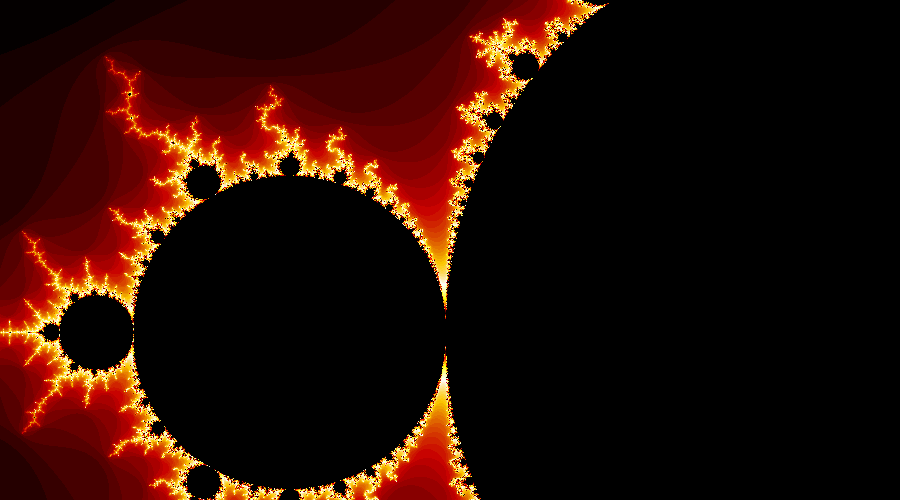

 0: Compiling shader:

 2: #define __SHADER_STAGE__
 3: 
 4: 
 5: 
 6: 
 7: layout(std140, binding = 0)
 8: uniform Mandelbrot
 9: {
10:     vec2 Center;
11:     int Iterations;
12:     float Scale;
13: };
14: 
15: 
16: layout(std140, binding = 1)
17: uniform PerView
18: {
19:     ivec2 ViewportSize;
20: };
21: 
22: 
23: layout(binding = 0)
24: uniform sampler2D transfer;
25: 
26: 
27: #ifdef Vertex
28: layout(location = 0) in vec2 DiffuseColorCoordinates;
29: layout(location = 1) in vec4 Positions;
30: layout(location = 0) out vec2 fs_DiffuseColorCoordinates;
31: void main()
32: {
33:     fs_DiffuseColorCoordinates = DiffuseColorCoordinates;
34:     gl_Position = Positions;
35: }
36: 
37: #endif
38: 
39: 
40: 
41: #ifdef Fragment
42: 
43: layout(location = 0) in vec2 fs_DiffuseColorCoordinates;
44: layout(location = 0) out vec4 ColorsOut;
45: void main()
46: {
47:     vec2 c = ((vec2(((float(ViewportSize.x) / float(ViewportSize.y)) * ((2.0 * fs_DiffuseColorCoordinates.x) - 1.0)), ((2.

In [30]:
let texture = 
    let path = @"C:\Users\hs\Desktop\aardvark.rendering\data\transfer.png"
    FileTexture(path, TextureParams.empty) :> ITexture
    
    
let center = V2d(0.743643887037158704752191506114774, -0.131825904205311970493132056385139) //* 0.5 + V2d(0.5, 0.5)

let s =
    runtime.CreateFramebufferSignature [
        DefaultSemantic.Colors, { format = RenderbufferFormat.Rgba8; samples = 1 }
    ]

let img = 
    Sg.fullScreenQuad
        |> Sg.uniform "Iterations" (Mod.constant 1000)
        |> Sg.uniform "Scale" (Mod.constant 0.4)
        |> Sg.uniform "Center" (Mod.constant <| center)
        |> Sg.uniform "TransferFunction" (Mod.constant texture)

        |> Sg.shader {
            do! Shader.mandelbrot
        }
        |> Aardvark.Notebooks.Rendering.toImg runtime 900 500
        
{ Html = img }

In [31]:
open Aardvark.UI
open Aardvark.UI.Primitives

open Aardvark.Base
open Aardvark.Base.Incremental
open Aardvark.Base.Rendering
open RenderControl.Model


let initialCamera = { 
        FreeFlyController.initial with 
            view = CameraView.lookAt (V3d.III * 3.0) V3d.OOO V3d.OOI
    }

let update (model : Model) (msg : Message) =
    match msg with
        | Camera m -> 
            { model with cameraState = FreeFlyController.update model.cameraState m }
        | CenterScene -> 
            { model with cameraState = initialCamera }
        | SetFiles s -> 
            printfn "open file: %A" s
            model

let viewScene (model : MModel) =
    Sg.box (Mod.constant C4b.Green) (Mod.constant Box3d.Unit)
     |> Sg.shader {
            do! DefaultSurfaces.trafo
            do! DefaultSurfaces.vertexColor
            do! DefaultSurfaces.simpleLighting
        }

let view (model : MModel) =

    let renderControl =
       FreeFlyController.controlledControl model.cameraState Camera (Frustum.perspective 60.0 0.1 100.0 1.0 |> Mod.constant) 
                    (AttributeMap.ofList [ style "width: 400px; height:400px; background: #222"; attribute "data-samples" "8"]) 
                    (viewScene model)

    div [] [
        text "Hello 3D"
        br []
        button [onClick (fun _ -> CenterScene)] [text "Center Scene"]
        br []
        br []
        renderControl
    ]


let threads (model : Model) = 
    FreeFlyController.threads model.cameraState |> ThreadPool.map Camera


let app =                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
    {
        unpersist = Unpersist.instance     
        threads = threads 
        initial = 
            { 
               cameraState = initialCamera
            }
        update = update 
        view = view
    }


In [32]:
{ Html = Aardvark.Notebooks.Runner.run runtime app }

{Html =
  "<iframe width="900" height="300" src="http://localhost:4321/"></iframe>";}